In [1]:
# listing modules followed by installation
!module list

Currently Loaded Modulefiles:
  1) discovery/2021-10-06         3) cuda/11.3
  2) anaconda3/2021.05(default)   4) nodejs/14.15.4


In [ ]:
!pip install torchvision==0.8.0

Defaulting to user installation because normal site-packages is not writeable
  Using cached torchvision-0.8.0-cp38-cp38-manylinux1_x86_64.whl (11.9 MB)
  Using cached torch-1.7.0-cp38-cp38-manylinux1_x86_64.whl (776.8 MB)
  Attempting uninstall: torch
    Found existing installation: torch 1.7.1
    Uninstalling torch-1.7.1:
      Successfully uninstalled torch-1.7.1


In [4]:
!pip install torch==1.7.0

Defaulting to user installation because normal site-packages is not writeable


In [5]:
!pip show torchaudio

In [3]:
# importing libraries
import torch
from torchvision import models, transforms, datasets
import glob
from torch import nn
import matplotlib.pyplot as plt
from time import time
from tqdm import tqdm

In [4]:
# function to prepare dataset
def prepare_dataset(resize_shape,path,samples):

  train_transforms = transforms.Compose([
      transforms.Resize(resize_shape),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])])

  test_transforms = transforms.Compose([
      transforms.Resize(resize_shape),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])])
  train_dataset = datasets.ImageFolder(train_data_path, transform=train_transforms)
  val_dataset = datasets.ImageFolder(train_data_path, transform=train_transforms)
  torch.manual_seed(1)

  num_train_samples = samples

  val_split = 0.2
  split = int(num_train_samples * val_split)
  indices = torch.randperm(num_train_samples)


  train_subset = torch.utils.data.Subset(train_dataset, indices[split:])
  val_subset = torch.utils.data.Subset(val_dataset, indices[:split])

  print('Total images in train dataset',len(train_subset))
  print('Total images in test dataset',len(val_subset))
  return train_subset,val_subset


In [5]:
# function to initialize and load the model
def model_loader(batch_size,train_subset,val_subset,model):
  batch_size = batch_size

  train_dataloader = torch.utils.data.DataLoader(
      dataset=train_subset, 
      batch_size=batch_size,
      shuffle=True)

  val_dataloader = torch.utils.data.DataLoader(
      dataset=val_subset,
      batch_size=batch_size,
      shuffle=False)
  classes = train_dataloader.dataset.dataset.classes
  resnet = model
  resnet= nn.DataParallel(resnet)
  for param in resnet.parameters():
    param.requires_grad = False
  in_features = resnet.fc.in_features
  fc = nn.Linear(in_features=in_features, out_features=len(classes))
  resnet.fc = fc
  params_to_update = []
  for name, param in resnet.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

        
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(params_to_update, lr=0.001)
  return resnet,criterion,optimizer,train_dataloader,val_dataloader

In [6]:
# function to train the model
def train(model,criterion,optimizer,train_dataloader,test_dataloader,print_every,num_epoch,device):
    steps = 0
    train_losses, val_losses = [], []
    train_accuracy,val_accuracy=[], []
    model.to(device)
    for epoch in tqdm(range(num_epoch)):
        running_loss = 0
        correct_train = 0
        total_train = 0
        start_time = time()
        iter_time = time()
        
        model.train()
        for i, (images, labels) in enumerate(train_dataloader):
            steps += 1
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            output = model(images)
            loss = criterion(output, labels)

            correct_train += (torch.max(output, dim=1)[1] == labels).sum()
            total_train += labels.size(0)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Logging
            if steps % print_every == 0:
                print(f'Epoch [{epoch + 1}]/[{num_epoch}]. Batch [{i + 1}]/[{len(train_dataloader)}].', end=' ')
                print(f'Train loss {running_loss / steps:.3f}.', end=' ')
                print(f'Train acc {correct_train / total_train * 100:.3f}.', end=' ')
                with torch.no_grad():
                    model.eval()
                    correct_val, total_val = 0, 0
                    val_loss = 0
                    for images, labels in test_dataloader:
                        images = images.to(device)
                        labels = labels.to(device)
                        output = model(images)
                        loss = criterion(output, labels)
                        val_loss += loss.item()
                        correct_val += (torch.max(output, dim=1)[1] == labels).sum()
                        total_val += labels.size(0)

                print(f'Val loss {val_loss / len(test_dataloader):.3f}. Val acc {correct_val / total_val * 100:.3f}.', end=' ')
                print(f'Took {time() - iter_time:.3f} seconds')
                iter_time = time()
              
                train_losses.append(running_loss / total_train)
                val_losses.append(val_loss / total_val)
                train_accuracy.append((correct_train / total_train) * 100)
                val_accuracy.append((correct_val / total_val) * 100)



        #print(f'Epoch took {time() - start_time}') 
        #torch.save(model, f'checkpoint_{correct_val / total_val * 100:.2f}')
        
    return model, train_losses, val_losses,train_accuracy,val_accuracy

In [7]:
import os
os.getcwd()

'/home/jaiswal.abh'

In [8]:
# checking the device type
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [9]:
# checking device count before training
torch.cuda.device_count()

2

In [10]:
# main function
if __name__=='__main__':
  train_data_path='asl_alphabet_train/asl_alphabet_train'
  train_subset,val_subset=prepare_dataset(64,train_data_path,10000)
  model=models.resnet50(pretrained=True)
  resnet,criterion,optimizer,train_dataloader,val_dataloader=model_loader(32,train_subset,val_subset,model)
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  #device='cpu'
  start=time()
  final_model,train_losses,val_losses,train_accuracy,val_accuracy=train(resnet,criterion,optimizer,train_dataloader,val_dataloader,150,5,device)
  end=time()
  print('On Device',device)
  print('Time taken',end-start)

Total images in train dataset 8000
Total images in test dataset 2000


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1]/[5]. Batch [150]/[250]. Train loss 0.533. Train acc 81.875. Val loss 0.226. Val acc 93.550. Took 12.690 seconds


 20%|██        | 1/5 [00:44<02:57, 44.50s/it]

Epoch [2]/[5]. Batch [50]/[250]. Train loss 0.036. Train acc 93.625. Val loss 0.144. Val acc 96.350. Took 6.331 seconds
Epoch [2]/[5]. Batch [200]/[250]. Train loss 0.066. Train acc 96.094. Val loss 0.112. Val acc 97.400. Took 11.585 seconds


 40%|████      | 2/5 [01:05<01:31, 30.56s/it]

Epoch [3]/[5]. Batch [100]/[250]. Train loss 0.027. Train acc 94.719. Val loss 0.101. Val acc 97.350. Took 8.314 seconds
Epoch [3]/[5]. Batch [250]/[250]. Train loss 0.039. Train acc 96.575. 

 60%|██████    | 3/5 [01:24<00:50, 25.44s/it]

Val loss 0.082. Val acc 97.850. Took 11.031 seconds
Epoch [4]/[5]. Batch [150]/[250]. Train loss 0.024. Train acc 94.938. Val loss 0.074. Val acc 97.950. Took 11.360 seconds


 80%|████████  | 4/5 [01:41<00:21, 21.98s/it]

Epoch [5]/[5]. Batch [50]/[250]. Train loss 0.005. Train acc 96.812. Val loss 0.074. Val acc 97.900. Took 5.705 seconds
Epoch [5]/[5]. Batch [200]/[250]. Train loss 0.011. Train acc 98.344. Val loss 0.058. Val acc 98.500. Took 11.292 seconds


100%|██████████| 5/5 [02:00<00:00, 24.18s/it]

On Device cuda
Time taken 124.12458777427673


In [11]:
# importing libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from torchvision import models
import torchvision.utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import numpy as np

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
# transforming and normalizing the image data
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(299),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), # ToTensor : [0, 255] -> [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(), # ToTensor : [0, 255] -> [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_data = dsets.ImageFolder('asl_alphabet_train/asl_alphabet_train/', train_transform)
val_dataset = datasets.ImageFolder('asl_alphabet_train/asl_alphabet_train/', transform=train_transform)
torch.manual_seed(1)

num_train_samples = 10000

val_split = 0.2
split = int(num_train_samples * val_split)
indices = torch.randperm(num_train_samples)

train_subset = torch.utils.data.Subset(train_data, indices[split:])
val_subset = torch.utils.data.Subset(val_dataset, indices[:split])
print('Total images in train dataset',len(train_subset))
print('Total images in test dataset',len(val_subset))

Total images in train dataset 8000
Total images in test dataset 2000


In [14]:
batch_size = 5

# subsetting data into different batches
train_loader = DataLoader(train_subset,
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(val_subset, 
                         batch_size=batch_size,
                         shuffle=True)


In [15]:
# function to display images from tensors
def imshow(img, title):
    img = torchvision.utils.make_grid(img, normalize=True)
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

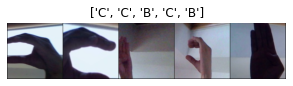

In [16]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(images, [train_data.classes[i] for i in labels])

In [18]:
# downloading the model
model = models.inception_v3(pretrained=True)

In [19]:
model.aux_logits = False

for parameter in model.parameters():
    parameter.requires_grad = False

In [20]:
# re-defining the fc layer for the model
classes = train_dataloader.dataset.dataset.classes
model.fc = nn.Linear(model.fc.in_features, len(classes))

In [21]:
# calling DataParallel class on the model
model = model.cuda()
model= nn.DataParallel(model)

In [22]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

In [23]:
num_epochs = 10

In [24]:
# training the model and capturing start and end time
start=time()
for epoch in range(num_epochs):
    total_batch = len(train_data)//batch_size

    for i, (batch_images, batch_labels) in enumerate(train_loader):
        
        X = batch_images.cuda()
        Y = batch_labels.cuda()

        pre = model(X)
        cost = loss(pre, Y)

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        if (i+1) % 500 == 0:
            print('Epoch [%d/%d], lter [%d/%d] Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, total_batch, cost.item()))
        
print('Time Taken ',time()-start)

Epoch [1/10], lter [500/17400] Loss: 0.8831
Epoch [1/10], lter [1000/17400] Loss: 0.2641
Epoch [1/10], lter [1500/17400] Loss: 0.4767
Epoch [2/10], lter [500/17400] Loss: 1.4074
Epoch [2/10], lter [1000/17400] Loss: 2.0947
Epoch [2/10], lter [1500/17400] Loss: 0.3688
Epoch [3/10], lter [500/17400] Loss: 1.7526
Epoch [3/10], lter [1000/17400] Loss: 0.3840
Epoch [3/10], lter [1500/17400] Loss: 0.6018
Epoch [4/10], lter [500/17400] Loss: 0.5714
Epoch [4/10], lter [1000/17400] Loss: 0.6862
Epoch [4/10], lter [1500/17400] Loss: 1.1049
Epoch [5/10], lter [500/17400] Loss: 0.5548
Epoch [5/10], lter [1000/17400] Loss: 0.4199
Epoch [5/10], lter [1500/17400] Loss: 0.9342
Epoch [6/10], lter [500/17400] Loss: 0.3516
Epoch [6/10], lter [1000/17400] Loss: 0.5437
Epoch [6/10], lter [1500/17400] Loss: 2.0357
Epoch [7/10], lter [500/17400] Loss: 0.3163
Epoch [7/10], lter [1000/17400] Loss: 0.8092
Epoch [7/10], lter [1500/17400] Loss: 1.1498
Epoch [8/10], lter [500/17400] Loss: 0.8146
Epoch [8/10], lter

In [42]:
# evaluating model's performance
# 
model.eval()

correct = 0
total = 0

for images, labels in test_loader:
    
    images = images.cuda()
    outputs = model(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()
    
print('Accuracy of test images: %f %%' % (100 * float(correct) / total))

Accuracy of test images: 89.450000 %
